In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame,Series
from scipy import stats
from sklearn.linear_model import LinearRegression

# 3. 数据可视化和摘要
## 3.1 数据可视化和摘要
### 数据摘要
首先使用pandas库中的方法将属性划分为标称型和数值型

In [2]:
def object_number_divide(dataset):
    winedata_columns = dataset.columns[1::]
    winedata_object_list = []
    winedata_number_list = []
    for obj in winedata_columns:
        if str(dataset[obj].dtypes)== 'object':
            winedata_object_list.append(obj)
        else:
            winedata_number_list.append(obj)
    return winedata_object_list,winedata_number_list

#### 发现下面中的第一个输出列表中的属性为标称型，后面的points和price的属性为数值型

In [3]:
dataset=pd.read_csv('./winemag-data_first150k.csv',header=0,sep='',delimiter=",", encoding='utf-8')
winedata_object_list,winedata_number_list = object_number_divide(dataset)
print(winedata_object_list,winedata_number_list)

['country', 'description', 'designation', 'province', 'region_1', 'region_2', 'variety', 'winery'] ['points', 'price']


#### 对标称属性，给出每个可能取值的频数
下面对于每个标称型属性中的属性值求出对应每个可能取值的频数

In [4]:
for wol in winedata_object_list:
    print('*'*30)
    print(wol)
    print(dataset[wol].value_counts())

******************************
country
US                        62397
Italy                     23478
France                    21098
Spain                      8268
Chile                      5816
Argentina                  5631
Portugal                   5322
Australia                  4957
New Zealand                3320
Austria                    3057
Germany                    2452
South Africa               2258
Greece                      884
Israel                      630
Hungary                     231
Canada                      196
Romania                     139
Slovenia                     94
Uruguay                      92
Croatia                      89
Bulgaria                     77
Moldova                      71
Mexico                       63
Turkey                       52
Georgia                      43
Lebanon                      37
Cyprus                       31
Brazil                       25
Macedonia                    16
Serbia                       14
M

#### 数值属性，给出最大、最小、均值、中位数、四分位数及缺失值的个数。
下面对于数值型属性，求出最大、最小、均值、中位数、四分位数及缺失值的个数。下面的每一行分别对应最小，最大，平均值，中位数，四分位数
和缺失值的个数。

In [5]:
cnt = len(dataset)
for wol in winedata_number_list:
    print('*'*30)
    print(wol)
    print(dataset[wol].min())
    print(dataset[wol].max())
    print(dataset[wol].mean())
    print(dataset[wol].median())
    print(dataset[wol].dropna().quantile(q=[0.25,0.75]))
    print(cnt-dataset[wol].count())

******************************
points
80
100
87.8884184721394
88.0
0.25    86.0
0.75    90.0
Name: points, dtype: float64
0
******************************
price
4.0
2300.0
33.13148249353299
24.0
0.25    16.0
0.75    40.0
Name: price, dtype: float64
13695


### 数据的可视化
#### 针对数值属性，
##### 绘制直方图，用qq图检验其分布是否为正态分布。
##### 绘制盒图，对离群值进行识别
首先对于points属性进行绘制直方图，QQ图和盒图，我们从QQ图中发现R=0.9885， 为正态分布，从盒图中发现，离群点的个数不是很多

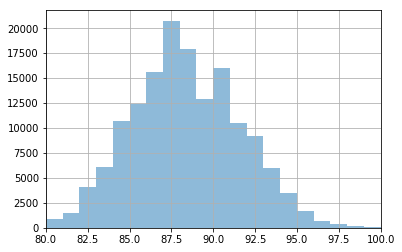

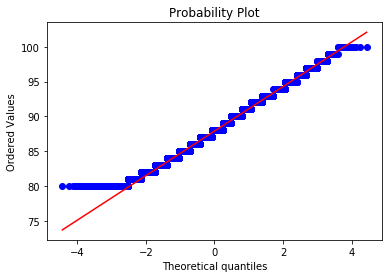

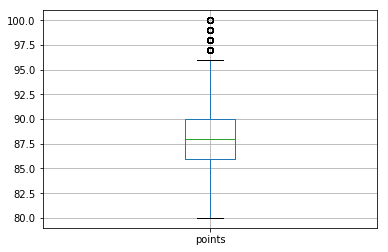

In [6]:
plt.xlim(80,100)
dataset['points'].hist(alpha=0.5, bins=20)
plt.show()
stats.probplot(dataset['points'], dist="norm", plot=plt)
plt.show()
data_price=DataFrame(dataset,columns=['points'])
data_price.boxplot()
plt.show()

对于price属性进行绘制直方图，QQ图和盒图，我们从QQ图中发现R=0.4923， 不是正态分布，从盒图中发现，离群点的个数有非常多

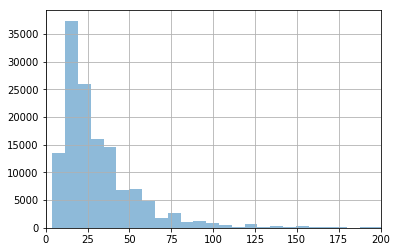

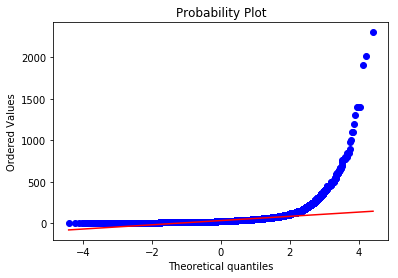

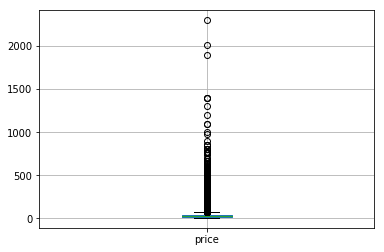

In [7]:
data_price=DataFrame(dataset,columns=['price'])
data_price = data_price.dropna()
plt.xlim(0,200)
data_price['price'].hist(alpha=0.5, bins=300)
plt.show()
stats.probplot(data_price['price'], dist="norm", plot=plt)
plt.show()
data_price.boxplot()
plt.show()

## 3.2 数据缺失的处理
### 观察数据集中缺失数据，分析其缺失的原因。
#### 下面对于数据集中缺失数据，分析其缺失的原因：
首先缺失的数据有以下几个：
1.对于country属性值缺失很少，为随机缺失，但是province，regin1属性的缺失依赖于country属性。
2.对于regin1缺失的元组，regin2的属性也会缺失
3.price属性缺失为随机缺失

##### 将缺失部分剔除
使用将缺失部分剔除的方法在上面的可视化处理中已经使用，所以将该种方法作为其他方法对照的baseline
##### 用最高频率值来填补缺失值
下面使用用最高频率值来填补缺失值，即使用属性值的众数来填补缺失值
在直方图上显示数据在属性值为20一栏上的的数量明显增加
在QQ图上显示，R=0.4772，在盒图上未发现明显变化

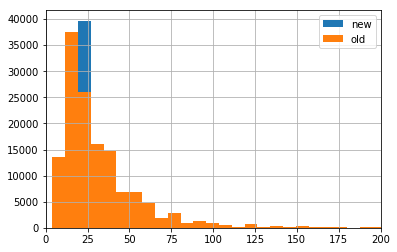

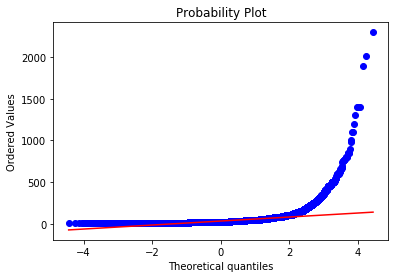

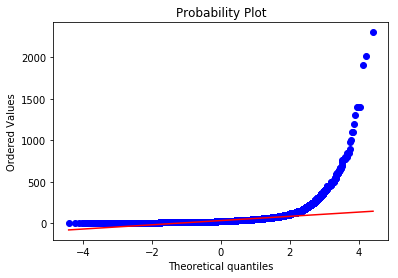

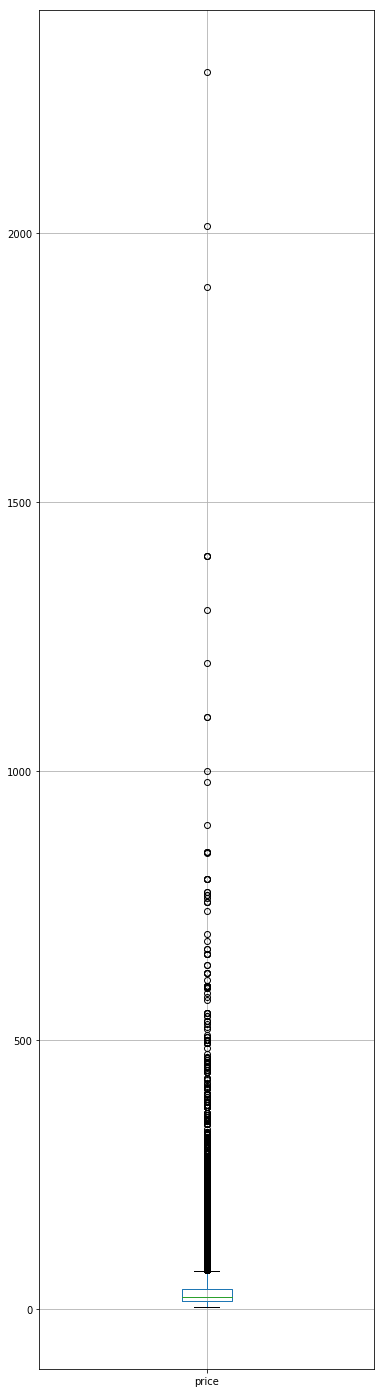

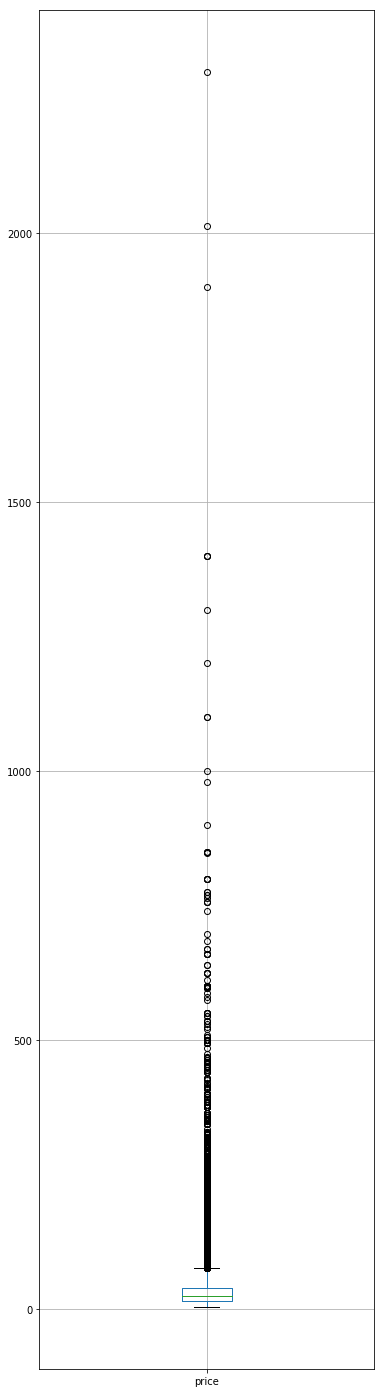

In [8]:
m = data_price['price'].mode()
data_price2 = DataFrame(dataset,columns=['price'])
data_price2['price'].fillna(m[0], inplace=True)
plt.xlim(0,200)
data_price2['price'].hist(bins=300)
data_price['price'].hist(bins=300)
plt.legend(['new','old'])
plt.show()
stats.probplot(data_price2['price'], dist="norm", plot=plt)
plt.show()
stats.probplot(data_price['price'], dist="norm", plot=plt)
plt.show()
data_price2.boxplot(figsize=(6,25))
plt.show()
data_price.boxplot(figsize=(6,25))
plt.show()

##### 通过属性的相关关系来填补缺失值
下面通过属性的相关关系来填补缺失值，对于price属性数据必然和points属性存在一定的相关关系，而且points属性是没有缺失值的，所以我们使用points属性的值来预测price属性的缺失值，建立这两个值之间的回归关系，然后进行预测。

In [9]:
cname = 'price'
linreg = LinearRegression()
liby=dataset.dropna(subset=[cname])
y=liby[[cname]]
zty=dataset[['price','points']]
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=0, n_estimators=50, n_jobs=-1)
known_price = zty[zty.price.notnull()].as_matrix()
unknown_price = zty[zty.price.isnull()].as_matrix()
y = known_price[:, :1]
X = known_price[:, 1:]
rfr.fit(X, y)
predictedprice = rfr.predict(unknown_price[:, 1:])
n3dataset=dataset
n3dataset.loc[(n3dataset.price.isnull()),'price'] = predictedprice

D:\APP\Anaconda\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


结果如下所示，从直方图可以看到，在很多数据段的数据均有所增加，但是数据段中心位置的区域预测的缺失值更多，这与我们用的回归方法和之前未缺失的数据分布有关，从数据的分布一致性来看，这样比采用众数的方法更好
QQ图的R=0.5063，更趋近于正态分布，这与预测方法相吻合
盒图未发现明显变化

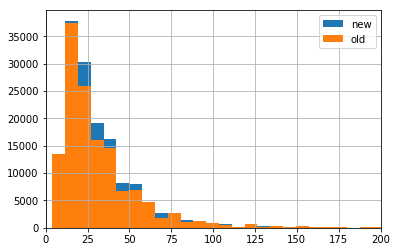

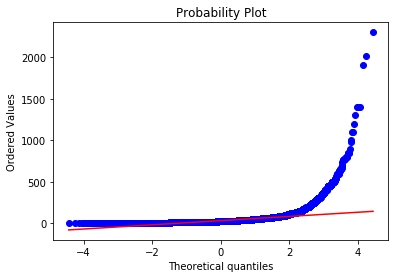

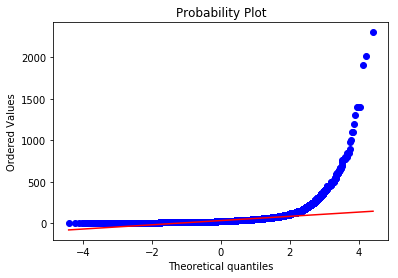

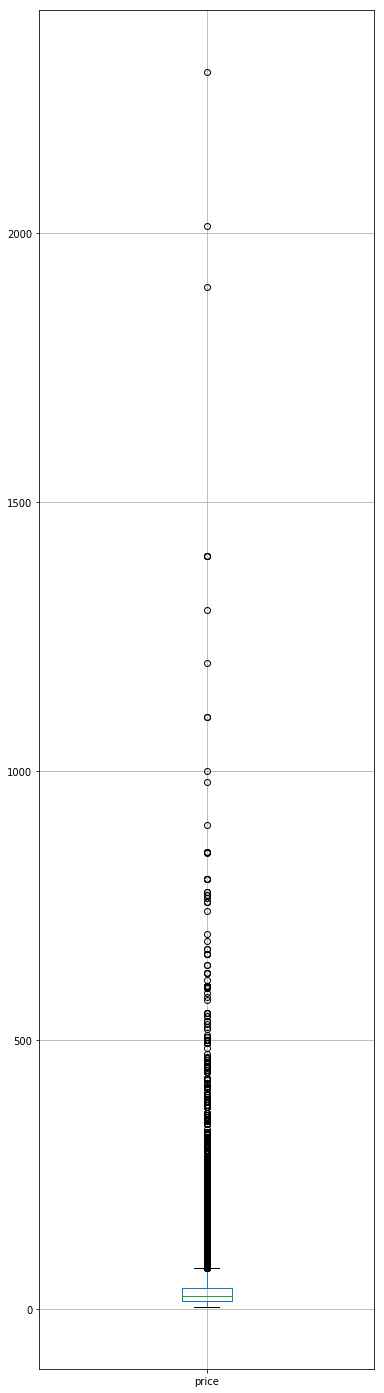

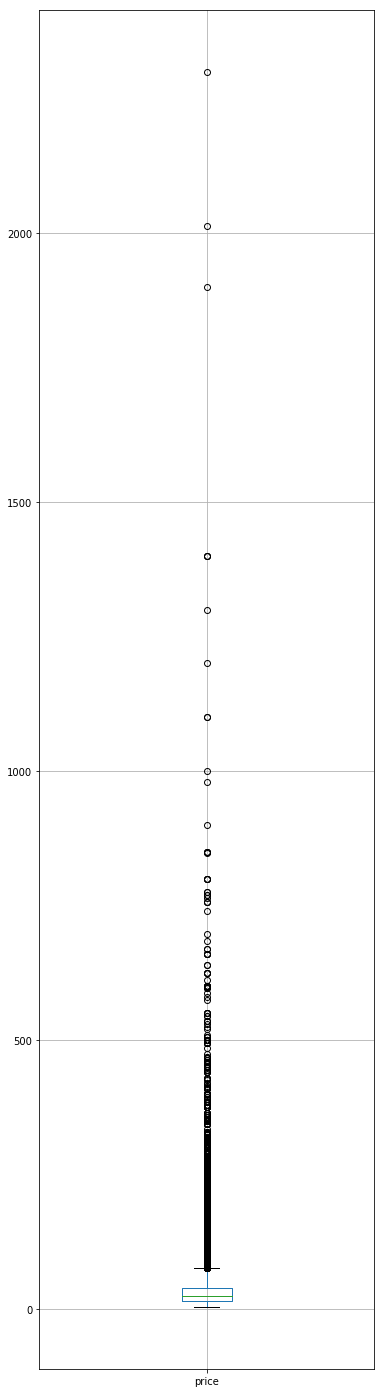

In [10]:
data_price3=DataFrame(n3dataset,columns=[cname])
plt.xlim(0,200)
data_price3[cname].hist(bins=300)
data_price['price'].hist(bins=300)
plt.legend(['new','old'])
plt.show()
stats.probplot(data_price3[cname], dist="norm", plot=plt)
plt.show()
stats.probplot(data_price['price'], dist="norm", plot=plt)
plt.show()
data_price3.boxplot(figsize=(6,25))
plt.show()
data_price.boxplot(figsize=(6,25))
plt.show()

##### 通过数据对象之间的相似性来填补缺失值
下面通过数据对象之间的相似性来填补缺失值，使用country和points两个属性值，采用近邻方法，由于points属性为数值型，country属性为标称型，所以无法使用一般的近邻方法，所以将points的优先级设为较高，country的优先级设为较低，然后使用近邻方法填补缺失值。

In [11]:
cty = dataset[['country','price','points']]
ans1=cty.sort_values(["points","country"],inplace=False,ascending=True)
ans2=ans1
while len(ans1)!=len(ans1.dropna()):
    ans1=ans1.fillna(method="bfill")
ans11= ans1['price'].as_matrix()
while len(ans2)!=len(ans2.dropna()):
    ans2=ans2.fillna(method='ffill')
ans22= ans2['price'].as_matrix()
ans3=(ans22+ans11)/2

结果如下所示，从直方图可以看到，在很多数据段的数据均有所增加，但是数据段中心位置的区域预测的缺失值更多，也从一定程度上说明了位于中间段，即20-30的price的缺失值较多
QQ图的R=0.5062，更趋近于正态分布，与回归方法相似
盒图未发现明显变化

D:\APP\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


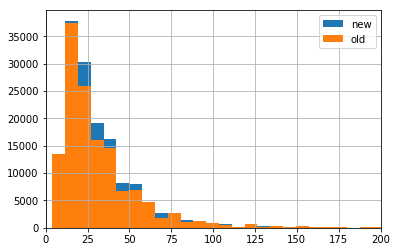

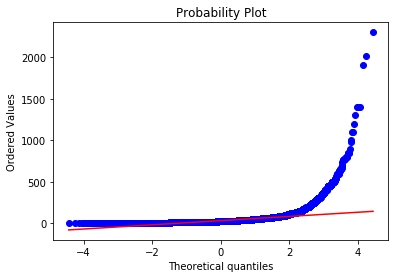

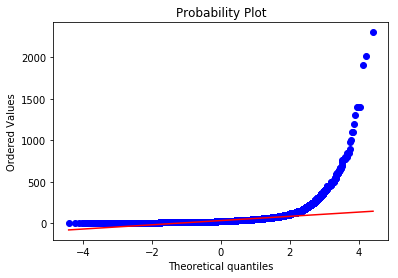

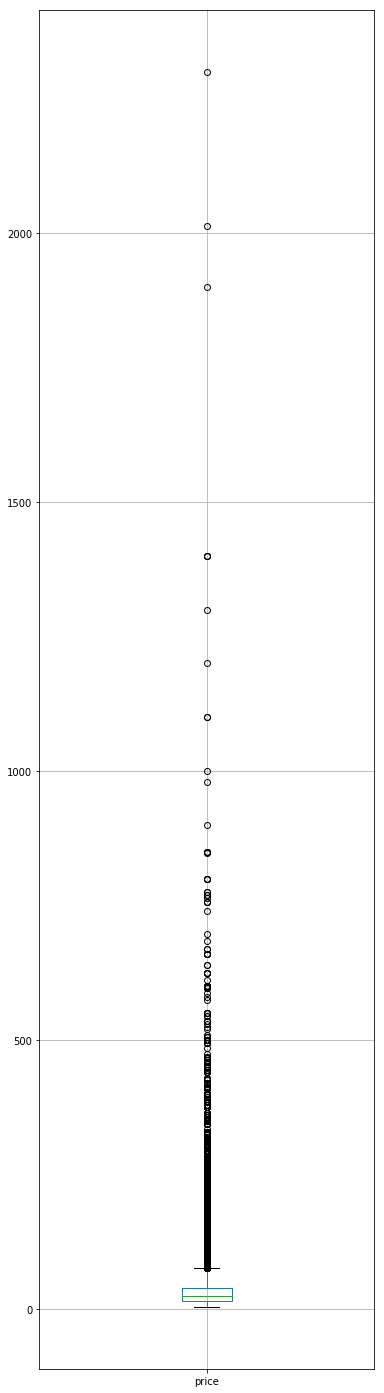

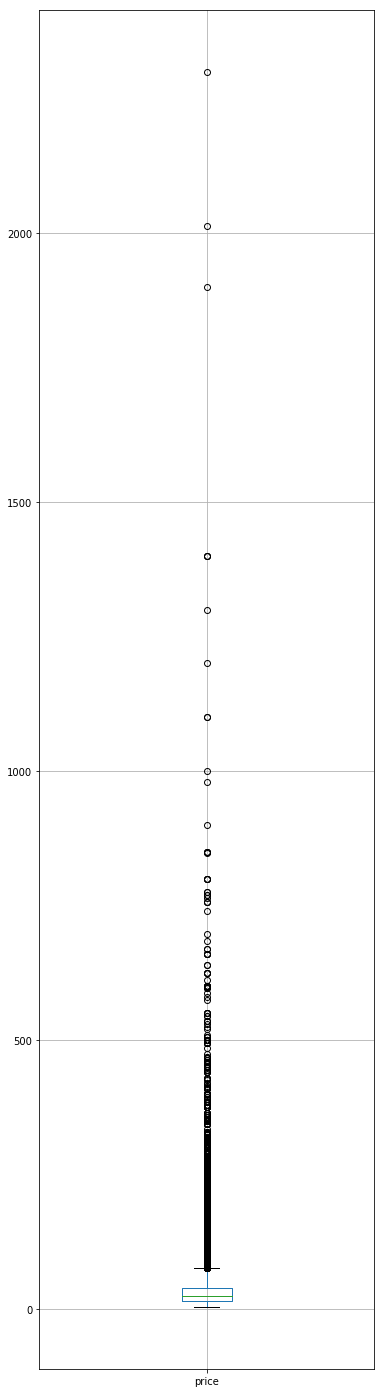

In [12]:
cty[cname]=pd.DataFrame(ans3)
d=DataFrame(cty,columns=[cname])
plt.xlim(0,200)
d[cname].hist(bins=300)
data_price['price'].hist(bins=300)
plt.legend(['new','old'])
plt.show()
stats.probplot(d[cname], dist="norm", plot=plt)
plt.show()
stats.probplot(data_price['price'], dist="norm", plot=plt)
plt.show()
d.boxplot(figsize=(6,25))
plt.show()
data_price.boxplot(figsize=(6,25))
plt.show()